In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(53080)
mean1 = [4, 4]
cov1 = [[2.5, 0], [0, 2.5]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, 250).T
mean2 = [11, 10]
cov2 = [[3.5, 0], [0, 2.5]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 250).T
mean3 = [5, 15]
cov3 = [[3.5, 0], [0, 2.5]]
x3, y3 = np.random.multivariate_normal(mean3, cov3, 250).T
mean4 = [15, 4]
cov4 = [[3.5, 0], [0, 2.5]]
x4, y4 = np.random.multivariate_normal(mean4, cov4, 250).T

x = np.r_[x1,x2,x3,x4]
y = np.r_[y1,y2,y3,y4]

ind1 = []
ind2 = []

for i in range(len(x)):
    ind1.append(np.logical_or(x[i]<0, x[i]>20))
    ind2.append(np.logical_or(y[i]<0, y[i]>20))
print(np.sum(ind1),np.sum(ind2))

for i in range(len(x)):
    if np.logical_or(x[i]<0, x[i]>20):
        x[i] = np.random.rand(1)*20
    if np.logical_or(y[i]<0, y[i]>20):
        y[i] = np.random.rand(1)*20


1 0


In [2]:
def Outbreaks(Size,N,Y0,farms,end,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    #Generate dataset (assume there are the same amount of animals at each farm)
    #np.random.seed(10)
    #x = Size*np.random.rand(N)
    #np.random.seed(11)
    #y = Size*np.random.rand(N)
    #Cows = np.array([250]*N)  #Number of cows at each farm
    #Sheep = np.array([250]*N)  #Number of cows at each farm
    Status = np.array([0]*N)    #Initial Status of each farm
    for i in range(Y0):
        Status[i] = 1

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
    def WhichGrid(x,y,XRange,YRange,XNum,YNum):
        #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
        #Returns a number from 1 to griddim^2
        return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    i = np.argsort(grid) #get indexed values after sort
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()+1) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max()+1)
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    def Kernel(dist_squared):
        dist_squared = np.asarray(dist_squared)
        is_scalar = False if dist_squared.ndim > 0 else True
        dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
        K = 1 / (pi * (1 + dist_squared**2))
        K[(dist_squared < 0.0138)] = 0.3093
        K[(dist_squared > 60*60)] = 0
        return(K if not is_scalar else K[0])

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))+1):
       for j in range(1,int(max(grid))+1):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
        Event = 0*Status
        INF = np.where(Status>5)[0]
        NI = INF.size # Note reported farms still infectious
        IGrids = grid[INF]-1
        
        for ii in range(NI):
            INFi = INF[ii]
            trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
            maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
            # Elementwise multiplication
            rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
            MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
            rng = np.random.rand(len(MaxProb))
            m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
            for n in range(len(m)):
                s = 1
                M = m[n]
                PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
                if (PAB == 1):
                    # Calculate the infection probability for each farm in the susceptible grid
                    leng = last_in_grid[M]-first_in_grid[M]+1
                    R = np.random.rand(leng)
                    for j in range(leng):
                        ind1 = first_in_grid[M]+j-1
                        Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                        if ((R[j] < Q) & (Status[ind1] == 0)):
                            Event[ind1] = 1
                else:
                    R = np.random.rand(Num[M])
                    # Loop through all susceptible farms in the grids where an infection event occurred.  
                    for j in range(Num[M]):
                        P = 1 - s*(1 - PAB)**(Num[M] - j)
                        if (R[j] < (PAB / P)):
                            s = 0
                            ind1=first_in_grid[M]+j-1
                            Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                            if ((R[j]< Q/P) & (Status[ind1] == 0)):
                                Event[ind1] = 1
        # Evolve the infection process of those farms which have been exposed and already infectious ones.  
        Status[Status > 0] += 1
        Status = Status + Event
        #m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
        #for i in range(len(m)):
        #    Status[m[i]]=-1;
        return {'Status':Status,'NI':NI}
    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<end, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
    
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if np.logical_or((E[-4]+I[-4]==0),len(I) == N):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full

    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (no_this[:,2]>5).astype(int)
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[291][0],coords[291][1]))
    dist = []
    for i in range(0,N):
        b = np.array((coords[i][0],coords[i][1]))
        dist.append(np.linalg.norm(b-index))
    to_return = np.c_[no_this[:,1],Status_ind,dist,Cows,Sheep]
    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep
    return(to_return)

In [3]:
import numpy as np
from random import randint
Size = 20
N = 1000   
np.random.seed(13)
Cows = np.array([randint(200,500) for p in range(N)])
np.random.seed(14)
Sheep = np.array([randint(200,500) for p in range(N)]) 
Outbreak = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)
Num_outbreaks = 500
for i in range(Num_outbreaks):
    new_Outbreak = np.r_[Outbreak,Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,x=x,y=y,Cows=Cows,Sheep=Sheep)]
    Outbreak = new_Outbreak 
run = np.ravel(list([i]*N for i in range(1,Num_outbreaks+2)))
data = np.c_[run,Outbreak]

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:92: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:101: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [33]:
#For ease turn data array into data frame
import pandas as pd
df = pd.DataFrame(data)
df.columns = ['run','farmID','Status','DistToIndex','NumCows','NumSheep']
long_clust_rand_size = df

In [34]:
long_clust_rand_size.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/long_clust_rand_size.pkl') 

In [6]:
#Group by farmID then add across farmIDs 
farm_Status = df[['Status']].groupby(df.farmID)
sum_Status = farm_Status.agg(np.sum)
#Get rid of hierarchical header for data merge
sum_Status.columns = sum_Status.columns.get_level_values(0)
sum_Status2 = pd.DataFrame(sum_Status).reset_index()
#Add rest of data covariates
subset = df[:1000][['farmID','DistToIndex','NumCows','NumSheep']]
clust_rand_size = pd.concat([sum_Status2, subset], axis=1, join_axes=[subset.index])
clust_rand_size.head()

,farmID,Status,farmID,DistToIndex,NumCows,NumSheep
0,1,226,1,7.116090,311,392
1,2,247,2,7.392643,423,402
2,3,500,3,5.399727,315,245
3,4,420,4,6.232599,305,423
4,5,469,5,6.263979,442,464


In [35]:
#Save (or pickle) the dataset for future use
clust_rand_size.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/clust_rand_size.pkl') 

In [36]:
#Read the pickled dataset back in - prevents having to run all above code again
import pandas as pd
clust_rand_size = pd.read_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/clust_rand_size.pkl')

In [7]:
N = 1000
Size = 20
#This is the index exposed farm in the outbreak function
Status = np.array([0]*N)    #Initial Status of each farm
for i in range(1):
    Status[i] = 1
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
    #Returns a number from 1 to griddim^2
    return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

#Set up the grid
grid = WhichGrid(x,y,Size,Size,10.0,10.0)
tmp = sorted(grid) #Sort grid values
i = np.argsort(grid) #get indexed values after sort
Status = Status[i]
x = x[i]
y = y[i]
np.where(Status==1)

(array([291]),)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


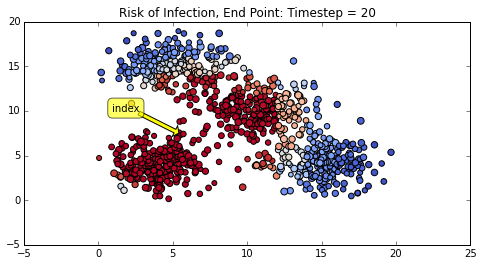

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.scatter(x,y,c=clust_rand_size['Status'],cmap=plt.cm.coolwarm,s=(Cows+Sheep)/20)
plt.title('Risk of Infection, End Point: Timestep = 20')
plt.annotate('index', xy = (x[291], y[291]), xytext = (-40, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round, pad=0.5', fc = 'yellow', alpha = 0.6),
        arrowprops=dict(facecolor='yellow', shrink=0.00005))


plt.show()

In [9]:
dist_diff = clust_rand_size['DistToIndex'] - clust_rand_size['DistToIndex'].mean()
cows_diff = clust_rand_size['NumCows'] - clust_rand_size['NumCows'].mean()
sheep_diff = clust_rand_size['NumSheep'] -clust_rand_size['NumSheep'].mean()
status = clust_rand_size['Status']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0.5) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = -0.05)
    
    b = Normal('b', mu=0., tau=0.001, value = [0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, b=b: invlogit(intercept + first_coef*dist_diff + b[0]*cows_diff 
                                               + b[1]*sheep_diff))
    
    y = Binomial('y', n=501, p=prob, value=status, observed=True)
    
    return locals()

In [18]:
chains = 2
iterations = 15000
burn = 9000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 15000 of 15000 complete in 35.1 sec

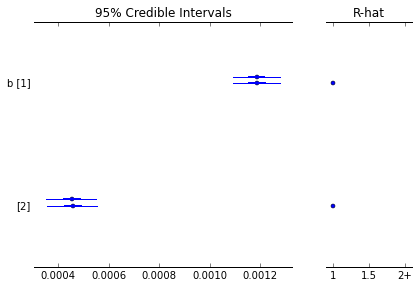

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.b)

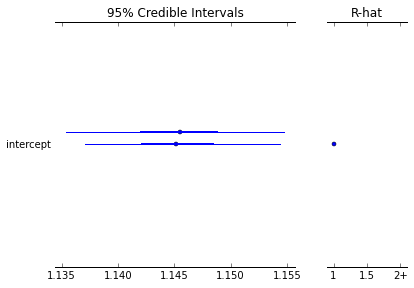

In [20]:
Matplot.summary_plot(M_pooled.intercept)

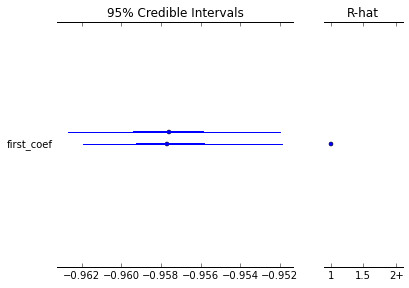

In [21]:
Matplot.summary_plot(M_pooled.first_coef)

Plotting intercept


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


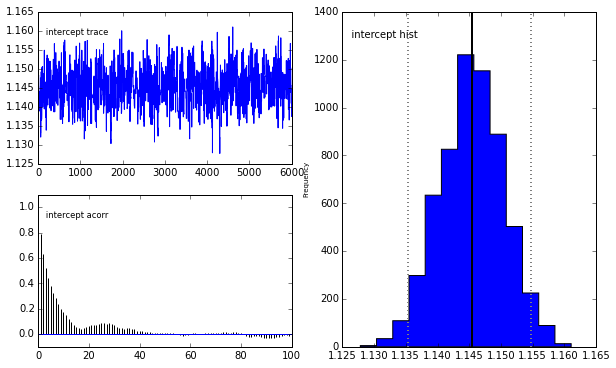

In [22]:
Matplot.plot(M_pooled.intercept)

Plotting b_0
Plotting b_1


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


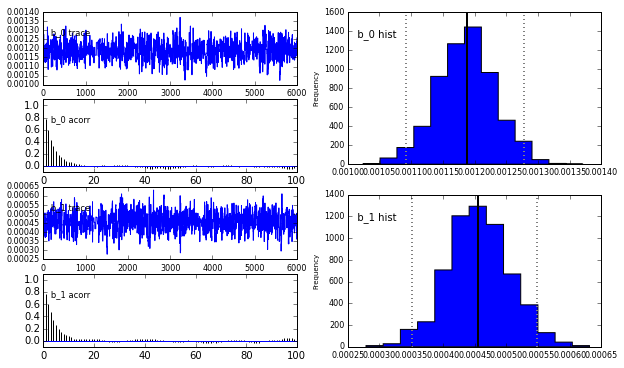

In [23]:
Matplot.plot(M_pooled.b, common_scale=False)

Plotting first_coef


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


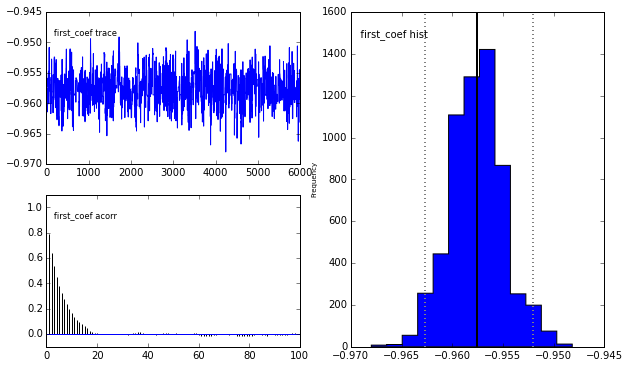

In [24]:
Matplot.plot(M_pooled.first_coef, common_scale=False)

In [25]:
from pymc import gelman_rubin
gelman_rubin(M_pooled)

{'b': [1.0001492076309031, 1.0014853854304746],
 'first_coef': 0.99992131214117019,
 'intercept': 1.0011480438492639,
 'prob': [1.0002954850859953,
  0.99983598680328589,
  1.0013130114959869,
  0.99985934511529839,
  1.000104884856803,
  1.0002745700540434,
  0.99983338229712848,
  0.99985199537427594,
  1.0005930328297756,
  1.0002419517033352,
  0.99986518764417631,
  1.0000105818144083,
  0.99983541657833575,
  0.99997020224763722,
  0.9999495392461587,
  1.0021814007096774,
  0.99988445671104098,
  0.99989315146987989,
  0.99989920649879482,
  0.9999552048642808,
  0.99983333464561652,
  1.0007346080735955,
  0.99985707726064266,
  0.99993110879486446,
  1.0000082138502,
  1.0032257209665301,
  1.0034584661469943,
  0.99987743091971237,
  1.0012680235688738,
  0.99987356983225617,
  0.99983911887947541,
  0.99983386850749012,
  0.99991221736391978,
  1.0005726665378296,
  1.0015528292267175,
  0.99997422304997496,
  0.99989173214937477,
  1.0018543663451751,
  1.0001214272594465,


In [26]:
M_pooled.b.summary()


b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.001            0.0              0.0              [ 0.001  0.001]
	0.0              0.0              0.0              [ 0.     0.001]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.001            0.001           0.001          0.001         0.001
	0.0              0.0             0.0            0.0           0.001
	


In [27]:
M_pooled.intercept.summary()


intercept:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.145            0.005            0.0              [ 1.137  1.155]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.136            1.142           1.145          1.149         1.155
	


In [28]:
M_pooled.first_coef.summary()


first_coef:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.958           0.003            0.0              [-0.962 -0.952]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.963           -0.959          -0.958         -0.956        -0.952
	


In [29]:
import numpy as np
#Intercept: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('intercept')[:].mean()),np.exp(np.percentile(M_pooled.trace('intercept')[:],2.5)),np.exp(np.percentile(M_pooled.trace('intercept')[:],97.5)))

(3.1436764483044, 3.1129496453931322, 3.1740939716692242)

In [30]:
#distance: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('first_coef')[:].mean()),np.exp(np.percentile(M_pooled.trace('first_coef')[:],2.5)),np.exp(np.percentile(M_pooled.trace('first_coef')[:],97.5)))

(0.38383123625891019, 0.3818840634763021, 0.38601820532144082)

In [31]:
# #cows: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('b')[:,0].mean()),np.exp(np.percentile(M_pooled.trace('b')[:,0],2.5)),np.exp(np.percentile(M_pooled.trace('b')[:,0],97.5)))

(1.0011871171709676, 1.0010930069044999, 1.0012795416794298)

In [32]:
# #sheep: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('b')[:,1].mean()),np.exp(np.percentile(M_pooled.trace('b')[:,1],2.5)),np.exp(np.percentile(M_pooled.trace('b')[:,1],97.5)))

(1.0004563046908832, 1.0003546987841563, 1.0005551215776978)